<a href="https://colab.research.google.com/github/ryrynbob/ust-deep-learning-2026/blob/main/Assignment_Nguyen_Ryan_Week5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ============================================================================
# SINGLE-CELL AUTOENCODER WITH LATENT EMBEDDING VISUALIZATION

## Ryan Nguyen

## Deep Learning
# ============================================================================
# Homework: Train classifier on single-cell gene expression data
# Dataset: single_cell.csv (200 genes, 100 cells, 4 groups)
# Task: Color cells by grouping, save latent embedding after every epoch, compile into GIF
# ============================================================================


In [1]:
# --------------------------
# 1. INSTALL & IMPORT LIBRARIES
# --------------------------
!pip install -q pandas numpy matplotlib seaborn scikit-learn tensorflow imageio
!pip install -q umap-learn


In [7]:
!pip install -q umap-learn imageio

## Import Libraries

In [2]:
import os
import io
import time
import imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input, backend as K
from tensorflow.keras.callbacks import Callback
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

In [3]:
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")


TensorFlow version: 2.19.0
GPU available: False


## Mount Drive and Load Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Option A: Load from your uploaded file
# If you uploaded single_cell.csv to Colab
try:
    df = pd.read_csv('single_cell.csv', index_col=0)
    print("✅ Loaded from local upload")
except:
    # Option B: Load from your Google Drive
    # Update this path to where you saved the file
    file_path = '/content/drive/MyDrive/CURRENT STUFF/School/Masters Program Classes/MSDS 6393 - Special Topics/single_cell.csv'
    df = pd.read_csv(file_path)
    print("✅ Loaded from Google Drive")

print(f"\n📊 Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()[:5]}... (total: {len(df.columns)})")
print(f"Group distribution:\n{df['group'].value_counts()}")


✅ Loaded from Google Drive

📊 Dataset shape: (100, 201)
Columns: ['Unnamed: 0', 'Gene1', 'Gene2', 'Gene3', 'Gene4']... (total: 201)
Group distribution:
group
Group3    38
Group4    27
Group1    21
Group2    14
Name: count, dtype: int64


## Preprocess Data

In [11]:
# --------------------------
# 3. PREPROCESSING
# --------------------------
# Separate features and labels
X = df.drop(columns=['group', 'Unnamed: 0']).copy() # Drop 'Unnamed: 0' as it's an identifier
y = df['group'].copy()

# Handle missing values (NA) - replace with column median
X = X.replace('NA', np.nan).astype(float)
X = X.fillna(X.median())

# Log1p transform for RNA-seq data (skewed counts)
X_log = np.log1p(X)

# Standardize (zero mean, unit variance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

print(f"\n✅ Preprocessed shape: {X_scaled.shape}")

# Encode labels for coloring
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_labels = le.classes_
n_classes = len(y_labels)
print(f"Groups: {y_labels}")


✅ Preprocessed shape: (100, 199)
Groups: ['Group1' 'Group2' 'Group3' 'Group4']


## Build Encoder

In [12]:
# --------------------------
# 4. BUILD AUTOENCODER
# --------------------------
input_dim = X_scaled.shape[1]   # 200 genes
encoding_dim = 32               # bottleneck size

def build_autoencoder(input_dim, encoding_dim):
    # Encoder
    encoder_input = keras.Input(shape=(input_dim,))
    x = layers.Dense(128, activation='relu')(encoder_input)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    encoded = layers.Dense(encoding_dim, activation='relu', name='bottleneck')(x)

    # Decoder
    x = layers.Dense(64, activation='relu')(encoded)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    decoded = layers.Dense(input_dim, activation='linear')(x)

    autoencoder = Model(encoder_input, decoded)
    encoder = Model(encoder_input, encoded)
    return autoencoder, encoder

autoencoder, encoder = build_autoencoder(input_dim, encoding_dim)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 199)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        25,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 199)            │        25,671 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,575 (287.40 KB)

 Trainable params: 72,807 (284.40 KB)

 Non-trainable params: 768 (3.00 KB)

## Capture Embeddings

In [13]:
class EmbeddingCallback(keras.callbacks.Callback):
    def __init__(self, encoder, data, labels):
        super().__init__()
        self.encoder = encoder
        self.data = data
        self.labels = labels
        self.embeddings = []   # store per epoch
        self.epochs = []

    def on_epoch_end(self, epoch, logs=None):
        emb = self.encoder.predict(self.data, verbose=0)
        self.embeddings.append(emb)
        self.epochs.append(epoch + 1)
        print(f"   Epoch {epoch+1}: embedding captured")

callback = EmbeddingCallback(encoder, X_scaled, y_encoded)


## Train

In [14]:
print("\n" + "="*50)
print("TRAINING AUTOENCODER")
print("="*50)

history = autoencoder.fit(
    X_scaled, X_scaled,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[callback],
    verbose=1
)

print(f"\nCaptured {len(callback.embeddings)} embeddings")



TRAINING AUTOENCODER
Epoch 1/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - loss: 1.9519   Epoch 1: embedding captured
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - loss: 1.9489 - val_loss: 0.9604
Epoch 2/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.8410   Epoch 2: embedding captured
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 1.8640 - val_loss: 0.9561
Epoch 3/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.8043   Epoch 3: embedding captured
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 1.7875 - val_loss: 0.9537
Epoch 4/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.7036   Epoch 4: embedding captured
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 1.6723 - val_loss: 0.9523
Epoch 5/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.6594   Epoch 5: embedding captured
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 1.5862 - val_loss: 0.9513
Epoch 6/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.5855   Epoch 6: embedding captured
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.5332 -

## Create UMAP Plots for Each EPOCH

In [16]:
print("\n" + "="*50)
print("CREATING EMBEDDING PLOTS")
print("="*50)

os.makedirs('emb_frames', exist_ok=True)
image_paths = []

for i, (epoch, emb) in enumerate(zip(callback.epochs, callback.embeddings)):
    # Reduce to 2D with UMAP
    reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=10)
    emb_2d = reducer.fit_transform(emb)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1],
                          c=y_encoded, cmap='tab10',
                          s=40, alpha=0.8, edgecolor='w', linewidth=0.5)
    plt.colorbar(scatter, ticks=range(len(y_labels)), label='Group')
    plt.title(f'Latent space – Epoch {epoch}')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.grid(alpha=0.3)

    path = f'emb_frames/epoch_{epoch:03d}.png'
    plt.savefig(path, dpi=100, bbox_inches='tight')
    plt.close()
    image_paths.append(path)
    print(f"   Saved {path}")


CREATING EMBEDDING PLOTS
   Saved emb_frames/epoch_001.png
   Saved emb_frames/epoch_002.png
   Saved emb_frames/epoch_003.png
   Saved emb_frames/epoch_004.png
   Saved emb_frames/epoch_005.png
   Saved emb_frames/epoch_006.png
   Saved emb_frames/epoch_007.png
   Saved emb_frames/epoch_008.png
   Saved emb_frames/epoch_009.png
   Saved emb_frames/epoch_010.png
   Saved emb_frames/epoch_011.png
   Saved emb_frames/epoch_012.png
   Saved emb_frames/epoch_013.png
   Saved emb_frames/epoch_014.png
   Saved emb_frames/epoch_015.png
   Saved emb_frames/epoch_016.png
   Saved emb_frames/epoch_017.png
   Saved emb_frames/epoch_018.png
   Saved emb_frames/epoch_019.png
   Saved emb_frames/epoch_020.png
   Saved emb_frames/epoch_021.png
   Saved emb_frames/epoch_022.png
   Saved emb_frames/epoch_023.png
   Saved emb_frames/epoch_024.png
   Saved emb_frames/epoch_025.png
   Saved emb_frames/epoch_026.png
   Saved emb_frames/epoch_027.png
   Saved emb_frames/epoch_028.png
   Saved emb_frames/ep

## Compile GIF

In [17]:
print("\n" + "="*50)
print("COMPILING GIF")
print("="*50)

gif_path = 'latent_evolution.gif'
with imageio.get_writer(gif_path, mode='I', duration=0.5, loop=0) as writer:
    for path in image_paths:
        img = imageio.imread(path)
        writer.append_data(img)

print(f"✅ GIF saved: {gif_path}")



COMPILING GIF
✅ GIF saved: latent_evolution.gif


## Display

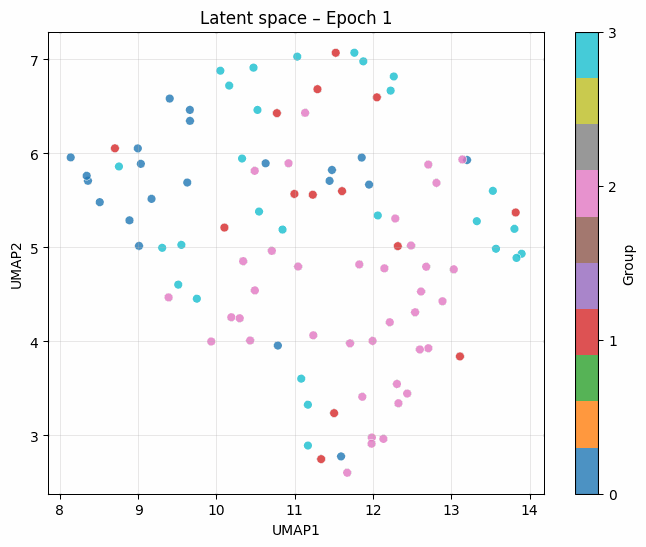

In [18]:
from IPython.display import Image as IPImage
display(IPImage(filename=gif_path))

## Download Result

In [19]:
from google.colab import files
!zip -r autoencoder_results.zip emb_frames/ latent_evolution.gif
files.download('autoencoder_results.zip')

  adding: emb_frames/ (stored 0%)
  adding: emb_frames/epoch_029.png (deflated 5%)
  adding: emb_frames/epoch_023.png (deflated 5%)
  adding: emb_frames/epoch_028.png (deflated 5%)
  adding: emb_frames/epoch_001.png (deflated 4%)
  adding: emb_frames/epoch_020.png (deflated 5%)
  adding: emb_frames/epoch_025.png (deflated 4%)
  adding: emb_frames/epoch_006.png (deflated 4%)
  adding: emb_frames/epoch_045.png (deflated 7%)
  adding: emb_frames/epoch_002.png (deflated 3%)
  adding: emb_frames/epoch_018.png (deflated 4%)
  adding: emb_frames/epoch_008.png (deflated 4%)
  adding: emb_frames/epoch_004.png (deflated 4%)
  adding: emb_frames/epoch_039.png (deflated 8%)
  adding: emb_frames/epoch_033.png (deflated 7%)
  adding: emb_frames/epoch_049.png (deflated 8%)
  adding: emb_frames/epoch_040.png (deflated 7%)
  adding: emb_frames/epoch_003.png (deflated 3%)
  adding: emb_frames/epoch_014.png (deflated 4%)
  adding: emb_frames/epoch_043.png (deflated 6%)
  adding: emb_frames/epoch_021.png 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>